# ABOUT


Datascientest's Datascientist continuous bootcamp - cohorte Mars2022 -  AeroBOT project

**Tutor**

* Alban THUET

**Authors:**

* Hélène ASSIR

</br>

---
</br>

**Version History**

Version | Date       | Author(s)  | Modification
--------|----------- | ---------  | --------------------------
2.1     | 30/09/2022 | H.A.       | Use df_for_Anomaly_prediction.pkl as data source 
2.0     | 22/09/2022 | H.A.       | Add GridSearch for model optimisation
1.0     | 24/08/2022 | H.A.       | Document creation

This notebook can be executed entirely. 

It

* mounts the GDrive of our AeroBot project @gmail account.

* loads the data from the `df_for_Anomaly_prediction.pkl` 

* Performs Anomaly target feature prediction : Bag Of Words approach with feature selection based on feature importance 

# IMPORT PACKAGES


In [ ]:
#######################
# Import packages
#######################
import numpy as np
import seaborn as sns
import math # for math.pi etc.
import time # time code execution

#######################
# Pandas
#######################
import pandas as pd
# Set pandas settings to show all data when using .head(), .columns etc.
pd.options.display.max_columns = None
pd.options.display.max_rows = None
pd.set_option("display.colheader_justify","left") # left-justify the print output of pandas

### Display full columnwidth
# Set pandas settings to display full text columns
#pd.options.display.max_colwidth = None
# Restore pandas settings to display standard colwidth
pd.reset_option('display.max_colwidth')

import itertools # Pour créer des iterateurs

# Package to show the progression of pandas operations
from tqdm import tqdm
# from tqdm.auto import tqdm  # for notebooks

# Create new `pandas` methods which use `tqdm` progress
# (can use tqdm_gui, optional kwargs, etc.)
tqdm.pandas()
# simply use .progress_apply() instead of .apply() on your pd.DataFram

######################
# PLOTTING
######################
import matplotlib.pyplot as plt
%matplotlib inline

#####################
# NLP 
#####################
import re # for Regular Expression handling
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet') # WordNet lemmatizer
nltk.download('omw-1.4') # necessary for WordNet lemmatizer
from nltk.tokenize import word_tokenize # Usual tokenizer
from nltk.tokenize import TweetTokenizer # Special tokenizer;  "we'll", "didn't", etc. are considered as one word
from sklearn.feature_extraction.text import CountVectorizer # Vectorization
from nltk.corpus import stopwords # Import stopwords from nltk.corpus
from nltk.stem.snowball import EnglishStemmer
##############################
# Undersampeling
##############################
from imblearn.under_sampling import RandomUnderSampler 
###############################
# ML preprocessing and models
###############################
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn import ensemble # random forest
from sklearn.svm import SVC
from sklearn import model_selection #,preprocessing

from sklearn.metrics import classification_report, confusion_matrix


###############################
# Other
###############################
import pickle as pkl # Saving data externally

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


# LOAD DATA

## Mount GDrive

In [ ]:
#@title
# Mount your Google Drive
from google.colab import drive
drive.mount('/content/drive/')

#check your present working directory 
%pwd

Mounted at /content/drive/


'/content'

In [ ]:
#@title
# move to the transformed data location (you can create a deeper structure, if needed, e.g. to save a trained model):
%cd /content/drive/MyDrive/data/transformed/

/content/drive/MyDrive/data/transformed


In [ ]:
#@title
!ls # list the content of the pwd

#!ls "/content/drive/MyDrive/Data_Science/Formations/DataScienceTest/projet/AeroBot/" # list contect of a speficic folder

 2022_09_11_7_4_3_raw_narr_BERT_BASE_frozen_max_length_345.pkl
 complaints-2022-08-05_13_55.csv
'Copy of Qualified abbreviations_20220718.xlsx.gsheet'
'Data Dictionnary.xlsx'
 data_for_BERT_multilabel_20220805.pkl
 logs
 model.png
 model_results
 Narrative_PP_stemmed_24072022_TRAIN.pkl
 Narrative_Raw_Stemmed_24072022_TRAIN.pkl
 Narrative_RegEx_subst_21072022_TRAIN.pkl
'Qualified abbreviations_20220707_test.csv'
'Qualified abbreviations_20220708.csv'
'Qualified abbreviations_20220718.csv'
'Qualified abbreviations_20220718_Google_sheet.gsheet'
 test_data_final.pkl
 train_data_final.pkl


## Load data from .pkl file


In [ ]:
# Load the TRAIN data (96986 entries)

%cd /content/drive/MyDrive/data/transformed/
with open("df_for_Anomaly_prediction.pkl", "rb") as f:
    loaded_data = pkl.load(f)

df = loaded_data
print("\nA Dataframe with", len(df), "entries has been loaded")

/content/drive/MyDrive/data/transformed

A Dataframe with 96986 entries has been loaded


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 96986 entries, 1163382 to 874642
Data columns (total 20 columns):
 #   Column                                        Non-Null Count  Dtype 
---  ------                                        --------------  ----- 
 0   Narrative                                     96986 non-null  object
 1   Anomaly                                       96986 non-null  object
 2   Narrative_PP_stemmed                          96986 non-null  object
 3   Narrative_Raw_Stemmed                         96986 non-null  object
 4   Narrative_Raw_Stemmed_str                     96986 non-null  object
 5   Narrative_PP_stemmed_str                      96986 non-null  object
 6   Anomaly_Deviation / Discrepancy - Procedural  96986 non-null  int64 
 7   Anomaly_Aircraft Equipment                    96986 non-null  int64 
 8   Anomaly_Conflict                              96986 non-null  int64 
 9   Anomaly_Inflight Event / Encounter            96986 non-null  int

## Define Anomaly_RootLabels_columns list from data set

In [ ]:
# Retriece the list of Anomaly label columns
Anomaly_RootLabels_columns = []

for col in df.columns:
  if 'Anomaly_' in str(col):
      Anomaly_RootLabels_columns.append(col)

In [ ]:
Anomaly_RootLabels_columns

['Anomaly_Deviation / Discrepancy - Procedural',
 'Anomaly_Aircraft Equipment',
 'Anomaly_Conflict',
 'Anomaly_Inflight Event / Encounter',
 'Anomaly_ATC Issue',
 'Anomaly_Deviation - Altitude',
 'Anomaly_Deviation - Track / Heading',
 'Anomaly_Ground Event / Encounter',
 'Anomaly_Flight Deck / Cabin / Aircraft Event',
 'Anomaly_Ground Incursion',
 'Anomaly_Airspace Violation',
 'Anomaly_Deviation - Speed',
 'Anomaly_Ground Excursion',
 'Anomaly_No Specific Anomaly Occurred']

# SUPERVISED NARRATIVE PREPROCESSING WITH IMPORTANCE


## FIRST DECISION TREE PREDICTION

## STANDARD SAMPLING - Function metrics_table_DT_grid  (DT classifiers only)
-Performs a decision tree model with standard sampling on the different targets and stock the results as well as the importance of features (tokens)
-Grid_search dictionnary is optional

In [ ]:
def metrics_table_DT_grid(data, target, vectorizer, classifier,grid_parameters_dict=None):
    """
    Return Prediction metrics and feature importance for Decision Trees
    /!\ works only for DT, since the other models don't return Feature importance

    Inputs: 
    - data: pd.Series containing the narratives as single string
    - target: a list of target labels
    - vectorizer instance. Lets you instantiate it with the desired settings
    - classifier (must be a decision tree as we calculate importance)
    - grid_parameters_dict (must be a dictionnary of parameters compatible with the classifier)   
    Return:
    - a DataFrame containing the classification reports for each target label
    - a DataFrame containing the feature importance for each token

    """

    # Time the function execution
    start_time = time.time()
    print(7*'-', "Execution started...", 7*'-', '\n')
    
    # Train-test split  
    X_train, X_test, y_train, y_test = train_test_split(data, target, 
                                                        test_size= 0.2, 
                                                        random_state = 12)


    # apply the vectorizer 
    X_train = vectorizer.fit_transform(X_train) 
    X_test = vectorizer.transform(X_test) 
    vocab = vectorizer.get_feature_names_out()
    print("Vocabulary length:" , len(vocab))

    # Instantiate variables
    df_importances = pd.DataFrame(vocab).rename(columns={0: 'token'})
    metrics_df_list = []

    # Loop through Anomaly labels
    for Anomaly in target.columns:

      print('Prediction of anomaly :', Anomaly)

      # Select the correct target data
      y_train_Anomaly = y_train[Anomaly]
      y_test_Anomaly = y_test[Anomaly]

      # Grid_Search option
      if grid_parameters_dict != None :
        grid_clf=model_selection.GridSearchCV(estimator=classifier,param_grid=grid_parameters_dict,scoring='f1')
        grid=grid_clf.fit(X_train, y_train)  
        print(pd.DataFrame.from_dict(grid.cv_results_).loc[:,['params', 'mean_test_score']]) 
        print(grid_clf.best_params_)
        classifier.set_params(**grid_clf.best_params_)
        print('Done Grid Optimisation')

      # Train & predict best classifier
      classifier.fit(X_train, y_train_Anomaly)
      y_pred = classifier.predict(X_test)
      print('Done Prediction')

      #########  FEATURE IMPORTANCE ################
      # write feature and its importance into a dict
      feats={}
      for feature,importance in zip(vocab, classifier.feature_importances_):
        feats[feature] = importance

      # Create a DataFrame from the dict. Each anomaly label gets a new column
      col_importance = 'Importance_' + Anomaly
      importance = pd.DataFrame.from_dict(feats, orient = 'index').reset_index().rename(columns = {'index': 'token', 0: col_importance})
      df_importances = df_importances.merge(importance, on = 'token', how = 'left')

      #########  CLASSIFICATION REPORT #############
      # Classif. report; dict format
      clf_rep = classification_report(y_test_Anomaly, y_pred, output_dict = True)
      
      # write classification report dictionnary into pd.DataFrame
      metrics = pd.DataFrame(clf_rep).reset_index().rename(columns = {'index': 'metric'})
      # Fill in with anomaly name
      metrics['anomaly'] = Anomaly
      if grid_parameters_dict == None :
        metrics['classifier'] = 'Decision Tree'  # [dt, rf, Word_Embedding, ...]
      else :
        metrics['classifier'] = 'Decision Tree (Grid)'  # [dt, rf, Word_Embedding, ...]
      metrics['undersampling'] = 0              # 1 if undersampling was applied
      metrics_df_list.append(metrics)

    
    metrics_exp = pd.concat(metrics_df_list)
    # Reset index, otherwise you get a repetition of 0,1,2,3
    metrics_exp = metrics_exp.reset_index().drop(columns =['index'])

    
    # Calculate and print time to execute
    end_time = time.time()
    print(f"--- DONE! It took {np.round((end_time - start_time)/60,1)} minutes ---")

    return metrics_exp, df_importances

### DT (Gini , Max_Depth=20), PP NARRATIVES,DEFAULT SAMPLING  (df_metrics_DT_PP.pkl)

In [ ]:
# Initializes the objects necesseray function inputs
data = df['Narrative_PP_stemmed_str']
target = df[Anomaly_RootLabels_columns]
clf = DecisionTreeClassifier(max_depth = 20)
vectorizer = CountVectorizer() 

In [ ]:
# Calls the function 
df_metrics, df_importances = metrics_table_DT_grid(data, target, vectorizer, clf)

# Fill in additionnal columns with metadata
df_metrics['preprocessing'] = 1          # 0 if raw, 1 if preprocessed
df_metrics['Count_Vectorizer_opts'] = np.nan # ['exclude_numerics'; 'min_df = 12'; ...]
# Reorder columns
df_metrics = df_metrics[['classifier', 'preprocessing', 'undersampling', 'Count_Vectorizer_opts',
                'anomaly', 'metric', '0', '1', 'accuracy', 'macro avg', 'weighted avg']]

------- Execution started... ------- 

Vocabulary length: 50030
Prediction of anomaly : Anomaly_Deviation / Discrepancy - Procedural
Done Prediction
Prediction of anomaly : Anomaly_Aircraft Equipment
Done Prediction
Prediction of anomaly : Anomaly_Conflict
Done Prediction
Prediction of anomaly : Anomaly_Inflight Event / Encounter
Done Prediction
Prediction of anomaly : Anomaly_ATC Issue
Done Prediction
Prediction of anomaly : Anomaly_Deviation - Altitude
Done Prediction
Prediction of anomaly : Anomaly_Deviation - Track / Heading
Done Prediction
Prediction of anomaly : Anomaly_Ground Event / Encounter
Done Prediction
Prediction of anomaly : Anomaly_Flight Deck / Cabin / Aircraft Event
Done Prediction
Prediction of anomaly : Anomaly_Ground Incursion
Done Prediction
Prediction of anomaly : Anomaly_Airspace Violation
Done Prediction
Prediction of anomaly : Anomaly_Deviation - Speed
Done Prediction
Prediction of anomaly : Anomaly_Ground Excursion
Done Prediction
Prediction of anomaly : Anom

In [ ]:
print(df_metrics.shape, " should be (56 , 11)")

(56, 11)  should be (56 , 11)


In [ ]:
# Saves the metrics into a pkl file
import pickle
%cd /content/drive/MyDrive/data/transformed/model_results/Importance_Feature_Selection_Grid_Search/
filename = 'df_metrics_DT_PP.pkl'
#enregistre le modèle
pickle.dump([df_metrics], open(filename, 'wb'))

/content/drive/MyDrive/data/transformed/model_results/Importance_Feature_Selection_Grid_Search


####Token Importance analysis

In [ ]:
len(df_importances)

50030

In [ ]:
df_metrics[df_metrics['metric'] == 'f1-score']

,classifier,preprocessing,undersampling,Count_Vectorizer_opts,anomaly,metric,0,1,accuracy,macro avg,weighted avg
2,Decision Tree,1,0,NaN,Anomaly_Deviation / Discrepancy - Procedural,f1-score,0.545957,0.760619,0.686514,0.653288,0.674889
6,Decision Tree,1,0,NaN,Anomaly_Aircraft Equipment,f1-score,0.867376,0.783270,0.835447,0.825323,0.834138
10,Decision Tree,1,0,NaN,Anomaly_Conflict,f1-score,0.927477,0.638927,0.879214,0.783202,0.875949
14,Decision Tree,1,0,NaN,Anomaly_Inflight Event / Encounter,f1-score,0.920635,0.574520,0.866223,0.747578,0.859345
18,Decision Tree,1,0,NaN,Anomaly_ATC Issue,f1-score,0.921223,0.508582,0.864213,0.714902,0.853896
22,Decision Tree,1,0,NaN,Anomaly_Deviation - Altitude,f1-score,0.954559,0.488791,0.916538,0.721675,0.912972
26,Decision Tree,1,0,NaN,Anomaly_Deviation - Track / Heading,f1-score,0.957966,0.459836,0.922002,0.708901,0.916622
30,Decision Tree,1,0,NaN,Anomaly_Ground Event / Encounter,f1-score,0.962167,0.451896,0.929220,0.707032,0.923130
34,Decision Tree,1,0,NaN,Anomaly_Flight Deck / Cabin / Aircraft Event,f1-score,0.974484,0.659015,0.952521,0.816750,0.949846
38,Decision Tree,1,0,NaN,Anomaly_Ground Incursion,f1-score,0.975654,0.569364,0.953913,0.772509,0.953117


In [ ]:
# Prints the top 10 most important features for each Anomaly label
for Anomaly in target.columns:
  col_importance = 'Importance_' + Anomaly
  topfeatures = df_importances.sort_values(by = col_importance, ascending = False).head(5)
  print(Anomaly,'\n',topfeatures[['token', col_importance]], '\n')

Anomaly_Deviation / Discrepancy - Procedural 
       token    Importance_Anomaly_Deviation / Discrepancy - Procedural
20119   emerg  0.136896                                               
28691    land  0.035296                                               
37717  realiz  0.029605                                               
17851  declar  0.020628                                               
44219    told  0.018057                                                

Anomaly_Aircraft Equipment 
       token     Importance_Anomaly_Aircraft Equipment
30197  mainten  0.316307                             
20119    emerg  0.113941                             
20252    engin  0.076388                             
36970      qrh  0.043111                             
39308   runway  0.020700                              

Anomaly_Conflict 
       token      Importance_Anomaly_Conflict
44461   traffic  0.275623                   
37350        ra  0.073143                   
15936    collis 

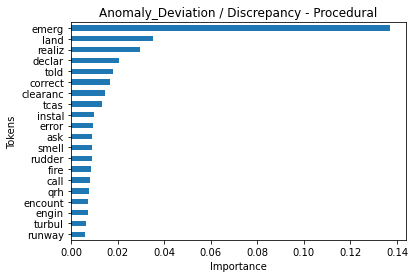

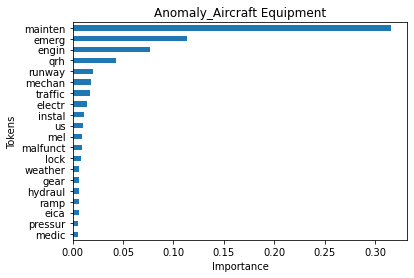

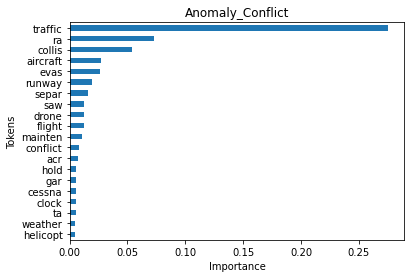

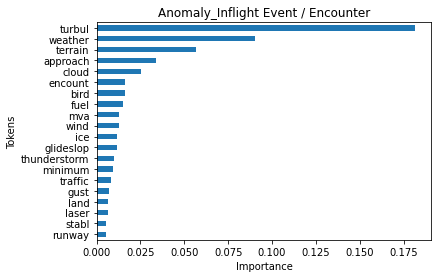

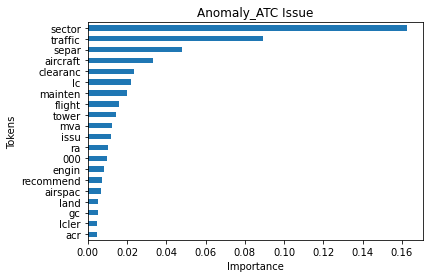

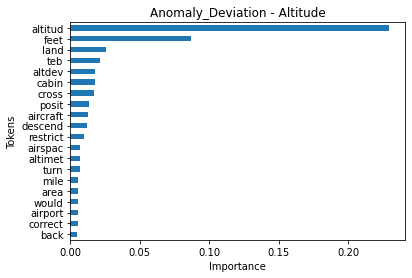

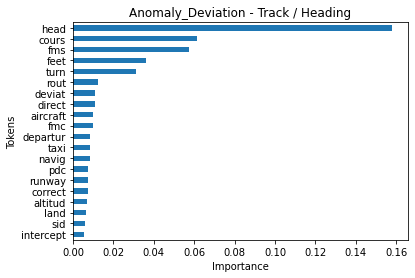

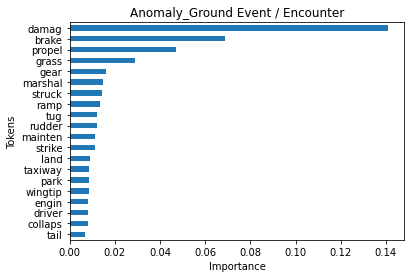

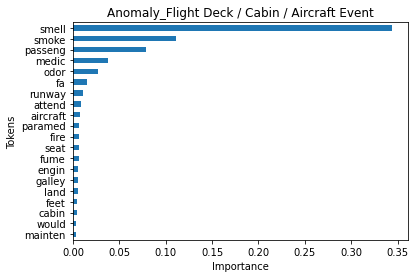

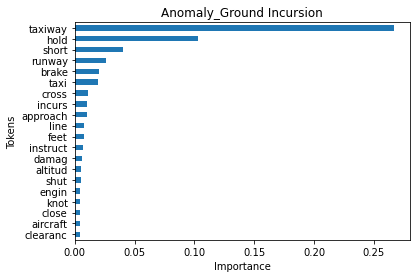

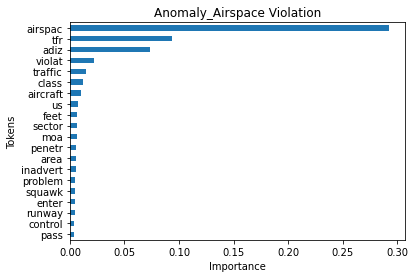

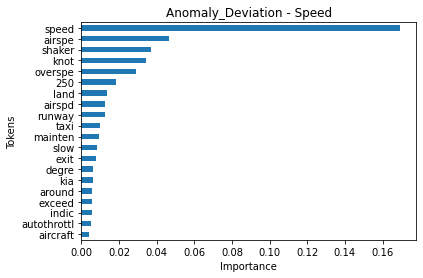

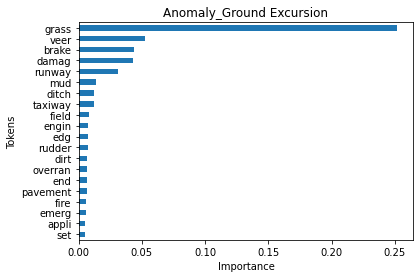

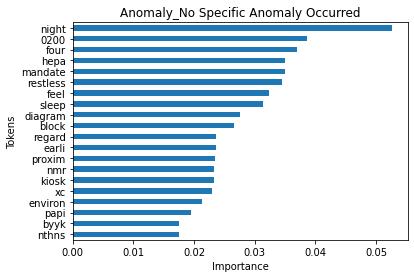

In [ ]:
# Plots the top 10 most important features for each Anomaly label
for Anomaly in target.columns:
  col_importance = 'Importance_' + Anomaly
  topfeatures = df_importances.sort_values(by = col_importance, ascending = True).tail(20)
  topfeatures.set_index('token').plot.barh(  y=[col_importance],legend=None) 
  plt.xlabel('Importance')
  plt.ylabel('Tokens')
  plt.title(Anomaly)


### Dictionnary : Token Importance 

In [ ]:
vocab_length_list=[20,30,50,100,250,500,750,1000,3000]

In [ ]:
# Defines a dictionnary (keys = anomalies) of dictionnaries (keys=vocab_length) of top N important tokens for the anomaly
dict_top_N_features={}
for Anomaly in Anomaly_RootLabels_columns:
  col_importance = 'Importance_' + Anomaly
  dict_top_features={}
  for vocab_length in vocab_length_list :
    topfeatures = list(df_importances.sort_values(by = col_importance, ascending = False).head(vocab_length)['token'])
    dict_top_features[vocab_length]=topfeatures
  dict_top_N_features[Anomaly]=dict_top_features

#### Analysis of top most important tokens / anomaly 

In [ ]:
# Defines a dictionnary (keys = vocab_length) of top N important  tokens for all the anomalies (deduplicated)
# i.e :  For 20 : we take the 20 most important tokens for each anomalies (potentially 280 tokens) and deduplicate the list : we get 189 tokens
dict_top_N_features_global={}
for vocab_length in vocab_length_list :
  vocab_total_list=[]
  for Anomaly in Anomaly_RootLabels_columns:
    col_importance = 'Importance_' + Anomaly
    liste=dict_top_N_features[Anomaly][vocab_length]  
    vocab_total_list=vocab_total_list+liste
  vocab_distinct_list=list(set(vocab_total_list))  
  dict_top_N_features_global[vocab_length]=vocab_distinct_list

In [ ]:
for vocab_length in vocab_length_list :
  print('Top ',vocab_length,' most important tokens (per anomaly) =>', len(dict_top_N_features_global[vocab_length]), 'tokens in total')

Top  20  most important tokens (per anomaly) => 190 tokens in total
Top  30  most important tokens (per anomaly) => 264 tokens in total
Top  50  most important tokens (per anomaly) => 397 tokens in total
Top  100  most important tokens (per anomaly) => 686 tokens in total
Top  250  most important tokens (per anomaly) => 1554 tokens in total
Top  500  most important tokens (per anomaly) => 2899 tokens in total
Top  750  most important tokens (per anomaly) => 3973 tokens in total
Top  1000  most important tokens (per anomaly) => 4797 tokens in total
Top  3000  most important tokens (per anomaly) => 6988 tokens in total


## SECOND DECISION TREE

### SECOND DT (Grid search), PP NARRATIVES,DEFAULT SAMPLING  , Vocab = N most important tokens (df_metrics_DT_PP_Impce_N.pkl) 

In [ ]:
# Saves the metrics into a pkl file
import pickle

In [ ]:
#vocab_length_list_to_run= [20,30,50,100,250,500,750,1000,3000] # list of available sizes which can be tested. 
# To add other lengths, first add the size in the "importance" dictionnary construction
vocab_length_list_to_run= [20]  # to test the collab 

In [ ]:
clf = DecisionTreeClassifier()
criterion = ['gini', 'entropy']
max_depth = [5,10,15,20]
grid_parameters_dict_DT=dict(criterion=criterion,
                      max_depth=max_depth)

In [ ]:
for vocab_length in vocab_length_list_to_run :
  df_second_metrics_compiled=[]
  #for Anomaly in ['Anomaly_Ground Event / Encounter','Anomaly_Conflict']:
  for Anomaly in Anomaly_RootLabels_columns:
    col_importance = 'Importance_' + Anomaly
    liste=dict_top_N_features[Anomaly][vocab_length]
    # Initializes the objects necesseray function inputs
    data = df['Narrative_PP_stemmed_str']
    target = df[[Anomaly]]
    vectorizer = CountVectorizer(vocabulary=liste) 

    # Calls the function 
    df_second_metrics, df_second_importances = metrics_table_DT_grid(data, target, vectorizer, clf,grid_parameters_dict=grid_parameters_dict_DT)

    # Fill in additionnal columns with metadata
    df_second_metrics['preprocessing'] = 1          # 0 if raw, 1 if preprocessed
    Count_Vectorizer_opts_label='impce= '+str(vocab_length) 
    df_second_metrics['Count_Vectorizer_opts'] = Count_Vectorizer_opts_label # ['exclude_numerics'; 'min_df = 12'; 'impce= 100'...]
    # Reorder columns
    df_second_metrics = df_second_metrics[['classifier', 'preprocessing', 'undersampling', 'Count_Vectorizer_opts',
                    'anomaly', 'metric', '0', '1', 'accuracy', 'macro avg', 'weighted avg']]
    df_second_metrics_compiled.append(df_second_metrics)
  
  metrics_exp_vocab_length = pd.concat(df_second_metrics_compiled)
  print(metrics_exp_vocab_length.shape, " should be (56 , 11)")

  %cd /content/drive/MyDrive/data/transformed/model_results/Importance_Feature_Selection_Grid_Search/
  filename = 'df_metrics_DT_PP_Impce_Grid_'+str(vocab_length)+'.pkl'
  #enregistre le modèle
  pickle.dump([metrics_exp_vocab_length], open(filename, 'wb'))

------- Execution started... ------- 

Vocabulary length: 20
Prediction of anomaly : Anomaly_Deviation / Discrepancy - Procedural
  params                                      mean_test_score
0      {'criterion': 'gini', 'max_depth': 5}  0.737850       
1     {'criterion': 'gini', 'max_depth': 10}  0.764541       
2     {'criterion': 'gini', 'max_depth': 15}  0.764247       
3     {'criterion': 'gini', 'max_depth': 20}  0.751944       
4   {'criterion': 'entropy', 'max_depth': 5}  0.737923       
5  {'criterion': 'entropy', 'max_depth': 10}  0.762905       
6  {'criterion': 'entropy', 'max_depth': 15}  0.763630       
7  {'criterion': 'entropy', 'max_depth': 20}  0.754299       
{'criterion': 'gini', 'max_depth': 10}
Done Grid Optimisation
Done Prediction
--- DONE! It took 0.5 minutes ---
------- Execution started... ------- 

Vocabulary length: 20
Prediction of anomaly : Anomaly_Aircraft Equipment
  params                                      mean_test_score
0      {'criterion': 'gini

## OTHER CLASSIFIERS

## FUNCTIONS

### STANDARD SAMPLING - Function metrics_table_grid (all classifiers)
-Performs a model with standard sampling on the different targets and stock the results  
-Grid search dictionnary is optional

In [ ]:
def metrics_table_grid(data, target, vectorizer, classifier,grid_parameters_dict=None):
    """
    Return Prediction metrics and feature importance for Decision Trees
    /!\ works only for DT, since the other models don't return Feature importance

    Inputs: 
    - data: pd.Series containing the narratives as single string
    - target: a list of target labels
    - vectorizer instance. Lets you instantiate it with the desired settings
    - classifier (must be a decision tree as we calculate importance)
    - grid_parameters_dict (must be a dictionnary of parameters compatible with the classifier)   
    
    Return:
    - a DataFrame containing the classification reports for each target label
    - a DataFrame containing the feature importance for each token

    """

    # Time the function execution
    start_time = time.time()
    print(7*'-', "Execution started...", 7*'-', '\n')
    
    # Train-test split  
    X_train, X_test, y_train, y_test = train_test_split(data, target, 
                                                        test_size= 0.2, 
                                                        random_state = 12)


    # apply the vectorizer 
    X_train = vectorizer.fit_transform(X_train) 
    X_test = vectorizer.transform(X_test) 
    vocab = vectorizer.get_feature_names_out()
    print("Vocabulary length:" , len(vocab))

    # Instantiate variables
    metrics_df_list = []

    # Loop through Anomaly labels
    for Anomaly in target.columns:

      print('Prediction of anomaly :', Anomaly)

      # Select the correct target data
      y_train_Anomaly = y_train[Anomaly]
      y_test_Anomaly = y_test[Anomaly]
      
      # Grid_Search option
      if grid_parameters_dict != None :
        grid_clf=model_selection.GridSearchCV(estimator=classifier,param_grid=grid_parameters_dict,scoring='f1')
        grid=grid_clf.fit(X_train, y_train_Anomaly)  
        print(pd.DataFrame.from_dict(grid.cv_results_).loc[:,['params', 'mean_test_score']]) 
        print(grid_clf.best_params_)
        classifier.set_params(**grid_clf.best_params_)
        print('Done Grid Optimisation')    
      # Train & predict
      classifier.fit(X_train, y_train_Anomaly)
      y_pred = classifier.predict(X_test)
      print('Done Prediction')   
      #########  CLASSIFICATION REPORT #############
      # Classif. report; dict format
      clf_rep = classification_report(y_test_Anomaly, y_pred, output_dict = True)
      # write classification report dictionnary into pd.DataFrame
      metrics = pd.DataFrame(clf_rep).reset_index().rename(columns = {'index': 'metric'})
      # Fill in with anomaly name
      metrics['anomaly'] = Anomaly
      metrics['undersampling'] = 0              # 1 if undersampling was applied
      metrics_df_list.append(metrics)

    
    metrics_exp = pd.concat(metrics_df_list)
    # Reset index, otherwise you get a repetition of 0,1,2,3
    metrics_exp = metrics_exp.reset_index().drop(columns =['index'])

    
    # Calculate and print time to execute
    end_time = time.time()
    print(f"--- DONE! It took {np.round((end_time - start_time)/60,1)} minutes ---")

    return metrics_exp 

### UNDERSAMPLING - Function metrics_table_US_grid (for all classifiers)
-Performs a model with under sampling on the different targets and stock the results
-Grid search is optional

In [ ]:
def metrics_table_US_grid(data, target, vectorizer, classifier,grid_parameters_dict=None):
    """
    Return Prediction metrics and feature importance for Decision Trees
    /!\ works only for DT, since the other models don't return Feature importance

    Inputs: 
    - data: pd.Series containing the narratives as single string
    - target: a list of target labels
    - vectorizer instance. Lets you instantiate it with the desired settings
    - classifier  
    - grid_parameters_dict (must be a dictionnary of parameters compatible with the classifier)   
   
    Return:
    - a DataFrame containing the classification reports for each target label
    - a DataFrame containing the feature importance for each token

    """

    # Time the function execution
    start_time = time.time()
    print(7*'-', "Execution started...", 7*'-', '\n')
    
    # add an extra column ones in the data DataFrame for convenience later during undersampeling
    data = pd.DataFrame(data)
    data['ones'] = 1

    # Train-test split  
    X_train, X_test, y_train, y_test = train_test_split(data, target, 
                                                        test_size= 0.2, 
                                                        random_state = 12)


    # Remove from X_test
    X_test = X_test.drop('ones', axis=1)
    X_test = X_test.squeeze()
    
    # Instantiate variables
    metrics_df_list = []

    # Loop through Anomaly labels
    for Anomaly in target.columns:

      print('Prediction of anomaly :', Anomaly)

      # Select the correct target data
      y_train_Anomaly = y_train[Anomaly]
      y_test_Anomaly = y_test[Anomaly]

      # Perform an undersampeling step
      rus = RandomUnderSampler()
      X_ru, y_ru = rus.fit_resample(X_train, y_train_Anomaly)

      # Remove the extra added column of ones from the X_ru and X_test 
      # Remove from X_ru
      X_ru = X_ru.drop('ones', axis=1)
      X_ru = X_ru.squeeze()

      # apply the vectorizer 
      X_ru = vectorizer.fit_transform(X_ru) 
      X_test_Anomaly = vectorizer.transform(X_test) 
      vocab = vectorizer.get_feature_names_out()
      print("Vocabulary length:" , len(vocab))

      # Grid_Search option
      if grid_parameters_dict != None :
        grid_clf=model_selection.GridSearchCV(estimator=classifier,param_grid=grid_parameters_dict,scoring='f1')
        grid=grid_clf.fit(X_ru, y_ru)  
        print(pd.DataFrame.from_dict(grid.cv_results_).loc[:,['params', 'mean_test_score']]) 
        print(grid_clf.best_params_)
        classifier.set_params(**grid_clf.best_params_)
        print('Done Grid Optimisation')    
      # Train & predict
      classifier.fit(X_ru, y_ru)
      y_pred = classifier.predict(X_test_Anomaly)
      print('Done Prediction')   



      #########  CLASSIFICATION REPORT #############
      # Classif. report; dict format
      clf_rep = classification_report(y_test_Anomaly, y_pred, output_dict = True)
      # write classification report dictionnary into pd.DataFrame
      metrics = pd.DataFrame(clf_rep).reset_index().rename(columns = {'index': 'metric'})
      # Fill in with anomaly name
      metrics['anomaly'] = Anomaly
      metrics['undersampling'] = 1  # 1 if undersampling was applied
      metrics_df_list.append(metrics)

    
    metrics_exp = pd.concat(metrics_df_list)
    # Reset index, otherwise you get a repetition of 0,1,2,3
    metrics_exp = metrics_exp.reset_index().drop(columns =['index'])
    # Calculate and print time to execute
    end_time = time.time()
    print(f"--- DONE! It took {np.round((end_time - start_time)/60,1)} minutes ---")

    return metrics_exp

## RANDOM FOREST

### RF DEFAULT SAMPLING (df_metrics_RF_PP_RN_MDF.pkl)
PP NARRATIVES x REMOVE Numbers x min_df setting 

In [ ]:
# initialize the objects necesseray function inputs
data = df['Narrative_PP_stemmed_str']
target = df[Anomaly_RootLabels_columns]
clf = ensemble.RandomForestClassifier(n_jobs = -1, random_state = 321)
vectorizer = CountVectorizer(token_pattern=r"\b[a-zA-Z][a-zA-Z]+\b",
                             min_df = 12)

In [ ]:
# Calls the function 
df_metrics = metrics_table_grid(data, target, vectorizer, clf)
# Fill in additionnal columns with metadata
df_metrics['classifier'] = 'Random Forest'  # [dt, rf, Word_Embedding, ...]
df_metrics['preprocessing'] = 1          # 0 if raw, 1 if preprocessed
df_metrics['Count_Vectorizer_opts'] = 'exclude_numerics;min_df = 12' # ['exclude_numerics'; 'min_df = 12'; ...]
# Reorder columns
df_metrics = df_metrics[['classifier', 'preprocessing', 'undersampling', 'Count_Vectorizer_opts',
                'anomaly', 'metric', '0', '1', 'accuracy', 'macro avg', 'weighted avg']]

In [ ]:
print(df_metrics.shape, " should be (56 , 11)")

(56, 11)  should be (56 , 11)


In [ ]:
# Saves the metrics into a pkl file
import pickle
%cd /content/drive/MyDrive/data/transformed/model_results/Importance_Feature_Selection_Grid_Search/
filename = 'df_metrics_RF_PP_RN_MDF.pkl'
#enregistre le modèle
pickle.dump([df_metrics], open(filename, 'wb'))

/content/drive/MyDrive/data/transformed/model_results/Importance_Feature_Selection


### RF (Grid search) DEFAULT SAMPLING (df_metrics_RF_PP_Impce_N.pkl)
PP NARRATIVES, Vocab = N most important tokens 

In [ ]:
# Saves the metrics into a pkl file
import pickle

In [ ]:
#vocab_length_list_to_run= [20,30,50,100,250,500,750,1000,3000] # list of available sizes which can be tested. 
# To add other lengths, first add the size in the "importance" dictionnary construction
vocab_length_list_to_run= [20]  # to test the collab 

In [ ]:
clf = ensemble.RandomForestClassifier()
grid_parameters_dict_RF = { 
    'n_estimators': [50,100],
    'max_features': ['sqrt'],
    'max_depth' : [5,10,None],
    'criterion' :['gini', 'entropy']
}


In [ ]:
for vocab_length in vocab_length_list_to_run :
  df_second_metrics_compiled=[]
  #for Anomaly in ['Anomaly_Ground Event / Encounter','Anomaly_Conflict']:
  for Anomaly in Anomaly_RootLabels_columns:
    col_importance = 'Importance_' + Anomaly
    liste=dict_top_N_features[Anomaly][vocab_length]
    
    # initialize the objects necesseray function inputs
    data = df['Narrative_PP_stemmed_str']
    target = df[[Anomaly]]
    vectorizer = CountVectorizer(vocabulary=liste)
    
    # Calls the function 
    df_second_metrics= metrics_table_grid(data, target, vectorizer, clf,grid_parameters_dict_RF)

    # Fill in additionnal columns with metadata
    df_second_metrics['classifier'] = 'Random Forest (Grid)'  # [dt, rf, Word_Embedding, ...]
    df_second_metrics['preprocessing'] = 1          # 0 if raw, 1 if preprocessed
    Count_Vectorizer_opts_label='impce= '+str(vocab_length) 
    df_second_metrics['Count_Vectorizer_opts'] = Count_Vectorizer_opts_label # ['exclude_numerics'; 'min_df = 12'; 'impce= 100'...]
    # Reorder columns
    df_second_metrics = df_second_metrics[['classifier', 'preprocessing', 'undersampling', 'Count_Vectorizer_opts',
                    'anomaly', 'metric', '0', '1', 'accuracy', 'macro avg', 'weighted avg']]



    df_second_metrics_compiled.append(df_second_metrics)
  
  metrics_exp_vocab_length = pd.concat(df_second_metrics_compiled)
  print(metrics_exp_vocab_length.shape, " should be (56 , 11)")

  %cd /content/drive/MyDrive/data/transformed/model_results/Importance_Feature_Selection_Grid_Search/
  filename = 'df_metrics_RF_PP_Impce_Grid_'+str(vocab_length)+'.pkl'
  #enregistre le modèle
  pickle.dump([metrics_exp_vocab_length], open(filename, 'wb'))

------- Execution started... ------- 

Vocabulary length: 30
Prediction of anomaly : Anomaly_Deviation / Discrepancy - Procedural
   params                                              mean_test_score
0   {'criterion': 'gini', 'max_depth': 5, 'max_fea...  0.777071       
1   {'criterion': 'gini', 'max_depth': 5, 'max_fea...  0.778099       
2   {'criterion': 'gini', 'max_depth': 10, 'max_fe...  0.786657       
3   {'criterion': 'gini', 'max_depth': 10, 'max_fe...  0.787590       
4   {'criterion': 'gini', 'max_depth': None, 'max_...  0.765073       
5   {'criterion': 'gini', 'max_depth': None, 'max_...  0.767462       
6   {'criterion': 'entropy', 'max_depth': 5, 'max_...  0.777538       
7   {'criterion': 'entropy', 'max_depth': 5, 'max_...  0.777566       
8   {'criterion': 'entropy', 'max_depth': 10, 'max...  0.786791       
9   {'criterion': 'entropy', 'max_depth': 10, 'max...  0.785964       
10  {'criterion': 'entropy', 'max_depth': None, 'm...  0.763939       
11  {'criterion': 

KeyboardInterrupt: ignored

### RF UNDER SAMPLING (df_metrics_RF_PP_US_RN_MDF.pkl)
PP NARRATIVES x REMOVE Numbers x min_df setting 


In [ ]:
# initialize the objects necesseray function inputs
data = df['Narrative_PP_stemmed_str']
target = df[Anomaly_RootLabels_columns]
clf = ensemble.RandomForestClassifier(n_jobs = -1, random_state = 321)
vectorizer = CountVectorizer(token_pattern=r"\b[a-zA-Z][a-zA-Z]+\b",
                             min_df = 12)

In [ ]:
# Calls the function 
df_metrics = metrics_table_US_grid(data, target, vectorizer, clf)


------- Execution started... ------- 

Prediction of anomaly : Anomaly_Deviation / Discrepancy - Procedural
Vocabulary length: 8208
Prediction of anomaly : Anomaly_Aircraft Equipment
Vocabulary length: 8128
Prediction of anomaly : Anomaly_Conflict
Vocabulary length: 5726
Prediction of anomaly : Anomaly_Inflight Event / Encounter
Vocabulary length: 5963
Prediction of anomaly : Anomaly_ATC Issue
Vocabulary length: 5618
Prediction of anomaly : Anomaly_Deviation - Altitude
Vocabulary length: 4297
Prediction of anomaly : Anomaly_Deviation - Track / Heading
Vocabulary length: 4354
Prediction of anomaly : Anomaly_Ground Event / Encounter
Vocabulary length: 4163
Prediction of anomaly : Anomaly_Flight Deck / Cabin / Aircraft Event
Vocabulary length: 4201
Prediction of anomaly : Anomaly_Ground Incursion
Vocabulary length: 3405
Prediction of anomaly : Anomaly_Airspace Violation
Vocabulary length: 3310
Prediction of anomaly : Anomaly_Deviation - Speed
Vocabulary length: 2662
Prediction of anomaly 

In [ ]:
df_metrics.head()

,metric,0,1,accuracy,macro avg,weighted avg,anomaly,undersampling
0,precision,0.675310,0.796790,0.746314,0.736050,0.748274,Anomaly_Deviation / Discrepancy - Procedural,1
1,recall,0.702595,0.775384,0.746314,0.738989,0.746314,Anomaly_Deviation / Discrepancy - Procedural,1
2,f1-score,0.688682,0.785941,0.746314,0.737312,0.747099,Anomaly_Deviation / Discrepancy - Procedural,1
3,support,7747.000000,11651.000000,0.746314,19398.000000,19398.000000,Anomaly_Deviation / Discrepancy - Procedural,1
4,precision,0.910672,0.829777,0.877255,0.870224,0.878702,Anomaly_Aircraft Equipment,1


In [ ]:
# Fill in additionnal columns with metadata
df_metrics['classifier'] = 'Random Forest'  # [dt, rf, Word_Embedding, ...]
df_metrics['preprocessing'] = 1          # 0 if raw, 1 if preprocessed
df_metrics['Count_Vectorizer_opts'] = 'exclude_numerics;min_df = 12' # ['exclude_numerics'; 'min_df = 12'; ...]
# Reorder columns
df_metrics = df_metrics[['classifier', 'preprocessing', 'undersampling', 'Count_Vectorizer_opts',
                'anomaly', 'metric', '0', '1', 'accuracy', 'macro avg', 'weighted avg']]

In [ ]:
print(df_metrics.shape, " should be (56 , 11)")

(56, 11)  should be (56 , 11)


In [ ]:
# Saves the metrics into a pkl file
import pickle
%cd /content/drive/MyDrive/data/transformed/model_results/Importance_Feature_Selection_Grid_Search/
filename = 'df_metrics_RF_PP_US_RN_MDF.pkl'
#enregistre le modèle
pickle.dump([df_metrics], open(filename, 'wb'))

/content/drive/MyDrive/data/transformed/model_results/Importance_Feature_Selection


### RF (Grid Search) UNDER SAMPLING (df_metrics_RF_PP_US_Impce_N.pkl)
PP NARRATIVES, Vocab = N most important tokens 

In [ ]:
#vocab_length_list_to_run= [20,30,50,100,250,500,750,1000,3000] # list of available sizes which can be tested. 
# To add other lengths, first add the size in the "importance" dictionnary construction
vocab_length_list_to_run= [20]  # to test the collab 

In [ ]:
clf = ensemble.RandomForestClassifier()
# grid_parameters_dict_RF = { 
#     'n_estimators': [50,100],
#     'max_features': ['auto', 'sqrt'],
#     'max_depth' : [5,10,None],
#     'criterion' :['gini', 'entropy']
# }
grid_parameters_dict_RF = { 
    'n_estimators': [50,100],
    'max_features': ['sqrt'],
    'max_depth' : [5,10,None],
    'criterion' :['gini', 'entropy']
}

In [ ]:
for vocab_length in vocab_length_list_to_run :
  df_second_metrics_compiled=[]
  #for Anomaly in ['Anomaly_Ground Event / Encounter','Anomaly_Conflict']:
  for Anomaly in Anomaly_RootLabels_columns:
    col_importance = 'Importance_' + Anomaly
    liste=dict_top_N_features[Anomaly][vocab_length]
    
    # initialize the objects necesseray function inputs
    data = df['Narrative_PP_stemmed_str']
    target = df[[Anomaly]]
    vectorizer = CountVectorizer(vocabulary=liste)
    
    # Calls the function 
    df_second_metrics = metrics_table_US_grid(data, target, vectorizer, clf)

    # Fill in additionnal columns with metadata
    df_second_metrics['classifier'] = 'Random Forest (Grid)'  # [dt, rf, Word_Embedding, ...]
    df_second_metrics['preprocessing'] = 1          # 0 if raw, 1 if preprocessed
    Count_Vectorizer_opts_label='impce= '+str(vocab_length) 
    df_second_metrics['Count_Vectorizer_opts'] = Count_Vectorizer_opts_label # ['exclude_numerics'; 'min_df = 12'; 'impce= 100'...]
    # Reorder columns
    df_second_metrics = df_second_metrics[['classifier', 'preprocessing', 'undersampling', 'Count_Vectorizer_opts',
                    'anomaly', 'metric', '0', '1', 'accuracy', 'macro avg', 'weighted avg']]

    df_second_metrics_compiled.append(df_second_metrics)
  
  metrics_exp_vocab_length = pd.concat(df_second_metrics_compiled)
  print(metrics_exp_vocab_length.shape, " should be (56 , 11)")

  %cd /content/drive/MyDrive/data/transformed/model_results/Importance_Feature_Selection_Grid_Search/
  filename = 'df_metrics_RF_PP_US_Impce_Grid_'+str(vocab_length)+'.pkl'
  #enregistre le modèle
  pickle.dump([metrics_exp_vocab_length], open(filename, 'wb'))

------- Execution started... ------- 

Prediction of anomaly : Anomaly_Deviation / Discrepancy - Procedural
Vocabulary length: 250
--- DONE! It took 2.3 minutes ---
------- Execution started... ------- 

Prediction of anomaly : Anomaly_Aircraft Equipment
Vocabulary length: 250
--- DONE! It took 1.7 minutes ---
------- Execution started... ------- 

Prediction of anomaly : Anomaly_Conflict
Vocabulary length: 250
--- DONE! It took 0.6 minutes ---
------- Execution started... ------- 

Prediction of anomaly : Anomaly_Inflight Event / Encounter
Vocabulary length: 250
--- DONE! It took 0.6 minutes ---
------- Execution started... ------- 

Prediction of anomaly : Anomaly_ATC Issue
Vocabulary length: 250
--- DONE! It took 0.5 minutes ---
------- Execution started... ------- 

Prediction of anomaly : Anomaly_Deviation - Altitude
Vocabulary length: 250
--- DONE! It took 0.2 minutes ---
------- Execution started... ------- 

Prediction of anomaly : Anomaly_Deviation - Track / Heading
Vocabulary

## GRADIENT BOOSTING

### GRADIENT BOOSTING  DEFAULT SAMPLING (df_metrics_RF_PP_RN_MDF.pkl)
PP NARRATIVES x REMOVE Numbers x min_df setting 

In [ ]:
# initialize the objects necesseray function inputs
data = df['Narrative_PP_stemmed_str']
target = df[Anomaly_RootLabels_columns]
#target = df[['Anomaly_Aircraft Equipment']]
clf = GradientBoostingClassifier(n_estimators = 100,learning_rate = 1.0,max_depth = 1)
vectorizer = CountVectorizer(token_pattern=r"\b[a-zA-Z][a-zA-Z]+\b",
                             min_df = 12)

In [ ]:
# Calls the function 
df_metrics = metrics_table_grid(data, target, vectorizer, clf)
# Fill in additionnal columns with metadata
df_metrics['classifier'] = 'Gradient Boosting'  # [dt, rf, Word_Embedding, ...]
df_metrics['preprocessing'] = 1          # 0 if raw, 1 if preprocessed
df_metrics['Count_Vectorizer_opts'] = 'exclude_numerics;min_df = 12' # ['exclude_numerics'; 'min_df = 12'; ...]
# Reorder columns
df_metrics = df_metrics[['classifier', 'preprocessing', 'undersampling', 'Count_Vectorizer_opts',
                'anomaly', 'metric', '0', '1', 'accuracy', 'macro avg', 'weighted avg']]

------- Execution started... ------- 

Vocabulary length: 9140
Prediction of anomaly : Anomaly_Deviation / Discrepancy - Procedural
Prediction of anomaly : Anomaly_Aircraft Equipment
Prediction of anomaly : Anomaly_Conflict
Prediction of anomaly : Anomaly_Inflight Event / Encounter
Prediction of anomaly : Anomaly_ATC Issue
Prediction of anomaly : Anomaly_Deviation - Altitude
Prediction of anomaly : Anomaly_Deviation - Track / Heading
Prediction of anomaly : Anomaly_Ground Event / Encounter
Prediction of anomaly : Anomaly_Flight Deck / Cabin / Aircraft Event
Prediction of anomaly : Anomaly_Ground Incursion
Prediction of anomaly : Anomaly_Airspace Violation
Prediction of anomaly : Anomaly_Deviation - Speed
Prediction of anomaly : Anomaly_Ground Excursion


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Prediction of anomaly : Anomaly_No Specific Anomaly Occurred
--- DONE! It took 6.2 minutes ---


In [ ]:
print(df_metrics.shape, " should be (56 , 11)")

(56, 11)  should be (56 , 11)


In [ ]:
# Saves the metrics into a pkl file
import pickle
%cd /content/drive/MyDrive/data/transformed/model_results/Importance_Feature_Selection_Grid_Search/
filename = 'df_metrics_GB_PP_RN_MDF.pkl'
#enregistre le modèle
pickle.dump([df_metrics], open(filename, 'wb'))

/content/drive/MyDrive/data/transformed/model_results/Importance_Feature_Selection


### GRADIENT BOOSTING (Grid search) DEFAULT SAMPLING (df_metrics_GB_PP_Impce_N.pkl) 
PP NARRATIVES Vocab = N most important tokens 

In [ ]:
# Saves the metrics into a pkl file
import pickle

In [ ]:
#vocab_length_list_to_run= [20,30,50,100,250,500,750,1000,3000] # list of available sizes which can be tested. 
# To add other lengths, first add the size in the "importance" dictionnary construction
vocab_length_list_to_run= [20]  # to test the collab 

In [ ]:
#clf = GradientBoostingClassifier(n_estimators = 100,learning_rate = 1.0,max_depth = 1)
clf = GradientBoostingClassifier()
    
# grid_parameters_dict_GP = { 
#     'n_estimators': [100,200, 500],
#     'learning_rate': [1.0,0.5],
#     'max_depth' : [4,5,6,7,8],
# }

grid_parameters_dict_GP = {'learning_rate': [0.1,0.5,1], #so called `eta` value
              'max_depth': [3,5],
              'min_samples_leaf': [1,5],
              'n_estimators': [100],#number of trees, change it to 1000 for better results
              }


In [ ]:
for vocab_length in vocab_length_list_to_run :
  df_second_metrics_compiled=[]
  #for Anomaly in ['Anomaly_Ground Event / Encounter','Anomaly_Conflict']:
  for Anomaly in Anomaly_RootLabels_columns:
    col_importance = 'Importance_' + Anomaly
    liste=dict_top_N_features[Anomaly][vocab_length]
    
    # initialize the objects necesseray function inputs
    data = df['Narrative_PP_stemmed_str']
    target = df[[Anomaly]]
    vectorizer = CountVectorizer(vocabulary=liste)
    
    # Calls the function 
    df_second_metrics= metrics_table_grid(data, target, vectorizer, clf,grid_parameters_dict_GP)

    # Fill in additionnal columns with metadata
    df_second_metrics['classifier'] = 'Gradient Boosting (Grid)'  # [dt, rf, Word_Embedding, ...]
    df_second_metrics['preprocessing'] = 1          # 0 if raw, 1 if preprocessed
    Count_Vectorizer_opts_label='impce= '+str(vocab_length) 
    df_second_metrics['Count_Vectorizer_opts'] = Count_Vectorizer_opts_label # ['exclude_numerics'; 'min_df = 12'; 'impce= 100'...]
    # Reorder columns
    df_second_metrics = df_second_metrics[['classifier', 'preprocessing', 'undersampling', 'Count_Vectorizer_opts',
                    'anomaly', 'metric', '0', '1', 'accuracy', 'macro avg', 'weighted avg']]



    df_second_metrics_compiled.append(df_second_metrics)
  
  metrics_exp_vocab_length = pd.concat(df_second_metrics_compiled)
  print(metrics_exp_vocab_length.shape, " should be (56 , 11)")

  %cd /content/drive/MyDrive/data/transformed/model_results/Importance_Feature_Selection_Grid_Search/
  filename = 'df_metrics_GB_PP_Impce_Grid_'+str(vocab_length)+'.pkl'
  #enregistre le modèle
  pickle.dump([metrics_exp_vocab_length], open(filename, 'wb'))

------- Execution started... ------- 

Vocabulary length: 50
Prediction of anomaly : Anomaly_Deviation / Discrepancy - Procedural
   params                                              mean_test_score
0   {'learning_rate': 0.1, 'max_depth': 3, 'min_sa...  0.791921       
1   {'learning_rate': 0.1, 'max_depth': 3, 'min_sa...  0.792132       
2   {'learning_rate': 0.1, 'max_depth': 5, 'min_sa...  0.791860       
3   {'learning_rate': 0.1, 'max_depth': 5, 'min_sa...  0.792126       
4   {'learning_rate': 0.5, 'max_depth': 3, 'min_sa...  0.789149       
5   {'learning_rate': 0.5, 'max_depth': 3, 'min_sa...  0.788437       
6   {'learning_rate': 0.5, 'max_depth': 5, 'min_sa...  0.783322       
7   {'learning_rate': 0.5, 'max_depth': 5, 'min_sa...  0.784300       
8   {'learning_rate': 1, 'max_depth': 3, 'min_samp...  0.781384       
9   {'learning_rate': 1, 'max_depth': 3, 'min_samp...  0.783612       
10  {'learning_rate': 1, 'max_depth': 5, 'min_samp...  0.772667       
11  {'learning_rat

KeyboardInterrupt: ignored

### GRADIENT BOOSTING UNDER SAMPLING (df_metrics_RF_PP_US_RN_MDF.pkl)
PP NARRATIVES x REMOVE Numbers x min_df setting 


In [ ]:
# initialize the objects necesseray function inputs
data = df['Narrative_PP_stemmed_str']
target = df[Anomaly_RootLabels_columns]
clf = GradientBoostingClassifier(n_estimators = 100,learning_rate = 1.0,max_depth = 1)
vectorizer = CountVectorizer(token_pattern=r"\b[a-zA-Z][a-zA-Z]+\b",
                             min_df = 12)

In [ ]:
# Calls the function 
df_metrics = metrics_table_US_grid(data, target, vectorizer, clf)


------- Execution started... ------- 

Prediction of anomaly : Anomaly_Deviation / Discrepancy - Procedural
Vocabulary length: 8197
Prediction of anomaly : Anomaly_Aircraft Equipment
Vocabulary length: 8100
Prediction of anomaly : Anomaly_Conflict
Vocabulary length: 5710
Prediction of anomaly : Anomaly_Inflight Event / Encounter
Vocabulary length: 5962
Prediction of anomaly : Anomaly_ATC Issue
Vocabulary length: 5601
Prediction of anomaly : Anomaly_Deviation - Altitude
Vocabulary length: 4302
Prediction of anomaly : Anomaly_Deviation - Track / Heading
Vocabulary length: 4399
Prediction of anomaly : Anomaly_Ground Event / Encounter
Vocabulary length: 4191
Prediction of anomaly : Anomaly_Flight Deck / Cabin / Aircraft Event
Vocabulary length: 4203
Prediction of anomaly : Anomaly_Ground Incursion
Vocabulary length: 3355
Prediction of anomaly : Anomaly_Airspace Violation
Vocabulary length: 3322
Prediction of anomaly : Anomaly_Deviation - Speed
Vocabulary length: 2639
Prediction of anomaly 

In [ ]:
df_metrics.head()

,metric,0,1,accuracy,macro avg,weighted avg,anomaly,undersampling
0,precision,0.619756,0.794611,0.712754,0.707183,0.724779,Anomaly_Deviation / Discrepancy - Procedural,1
1,recall,0.726475,0.703631,0.712754,0.715053,0.712754,Anomaly_Deviation / Discrepancy - Procedural,1
2,f1-score,0.668885,0.746358,0.712754,0.707622,0.715418,Anomaly_Deviation / Discrepancy - Procedural,1
3,support,7747.000000,11651.000000,0.712754,19398.000000,19398.000000,Anomaly_Deviation / Discrepancy - Procedural,1
4,precision,0.893760,0.823838,0.865605,0.858799,0.866127,Anomaly_Aircraft Equipment,1


In [ ]:
# Fill in additionnal columns with metadata
df_metrics['classifier'] = 'Gradient Boosting'  # [dt, rf, Word_Embedding, ...]
df_metrics['preprocessing'] = 1          # 0 if raw, 1 if preprocessed
df_metrics['Count_Vectorizer_opts'] = 'exclude_numerics;min_df = 12' # ['exclude_numerics'; 'min_df = 12'; ...]
# Reorder columns
df_metrics = df_metrics[['classifier', 'preprocessing', 'undersampling', 'Count_Vectorizer_opts',
                'anomaly', 'metric', '0', '1', 'accuracy', 'macro avg', 'weighted avg']]

In [ ]:
print(df_metrics.shape, " should be (56 , 11)")

(56, 11)  should be (56 , 11)


In [ ]:
# Saves the metrics into a pkl file
import pickle
%cd /content/drive/MyDrive/data/transformed/model_results/Importance_Feature_Selection_Grid_Search/
filename = 'df_metrics_GB_PP_US_RN_MDF.pkl'
#enregistre le modèle
pickle.dump([df_metrics], open(filename, 'wb'))

/content/drive/MyDrive/data/transformed/model_results/Importance_Feature_Selection


### GRADIENT BOOSTING (Grid search)  UNDER SAMPLING (df_metrics_GB_PP_US_Impce_N.pkl) 
PP NARRATIVES Vocab = N most important tokens 

In [ ]:
# Saves the metrics into a pkl file
import pickle

In [ ]:
#vocab_length_list_to_run= [20,30,50,100,250,500,750,1000,3000] # list of available sizes which can be tested. 
# To add other lengths, first add the size in the "importance" dictionnary construction
vocab_length_list_to_run= [20]  # to test the collab 

In [ ]:
clf = GradientBoostingClassifier()
# # To check the parameters of a given classifier
clf.get_params().keys()

dict_keys(['bootstrap', 'ccp_alpha', 'class_weight', 'criterion', 'max_depth', 'max_features', 'max_leaf_nodes', 'max_samples', 'min_impurity_decrease', 'min_samples_leaf', 'min_samples_split', 'min_weight_fraction_leaf', 'n_estimators', 'n_jobs', 'oob_score', 'random_state', 'verbose', 'warm_start'])

In [ ]:
clf = GradientBoostingClassifier()
    

grid_parameters_dict_GP = {'learning_rate': [0.1,0.5,1], #so called `eta` value
              'max_depth': [3,5],
              'min_samples_leaf': [1,5],
              'n_estimators': [10,50,100], 
              }


In [ ]:
for vocab_length in vocab_length_list_to_run :
  df_second_metrics_compiled=[]
  #for Anomaly in ['Anomaly_Ground Event / Encounter','Anomaly_Conflict']:
  for Anomaly in Anomaly_RootLabels_columns:
    col_importance = 'Importance_' + Anomaly
    liste=dict_top_N_features[Anomaly][vocab_length]
    
    # initialize the objects necesseray function inputs
    data = df['Narrative_PP_stemmed_str']
    target = df[[Anomaly]]
    vectorizer = CountVectorizer(vocabulary=liste)
    
    # Calls the function 
    df_second_metrics= metrics_table_US_grid(data, target, vectorizer, clf,grid_parameters_dict_GP)

    # Fill in additionnal columns with metadata
    df_second_metrics['classifier'] = 'Gradient Boosting (Grid)'  # [dt, rf, Word_Embedding, ...]
    df_second_metrics['preprocessing'] = 1          # 0 if raw, 1 if preprocessed
    Count_Vectorizer_opts_label='impce= '+str(vocab_length) 
    df_second_metrics['Count_Vectorizer_opts'] = Count_Vectorizer_opts_label # ['exclude_numerics'; 'min_df = 12'; 'impce= 100'...]
    # Reorder columns
    df_second_metrics = df_second_metrics[['classifier', 'preprocessing', 'undersampling', 'Count_Vectorizer_opts',
                    'anomaly', 'metric', '0', '1', 'accuracy', 'macro avg', 'weighted avg']]



    df_second_metrics_compiled.append(df_second_metrics)
  
  metrics_exp_vocab_length = pd.concat(df_second_metrics_compiled)
  print(metrics_exp_vocab_length.shape, " should be (56 , 11)")

  %cd /content/drive/MyDrive/data/transformed/model_results/Importance_Feature_Selection_Grid_Search/
  filename = 'df_metrics_GB_PP_US_Impce_Grid_'+str(vocab_length)+'.pkl'
  #enregistre le modèle
  pickle.dump([metrics_exp_vocab_length], open(filename, 'wb'))

------- Execution started... ------- 

Prediction of anomaly : Anomaly_Deviation / Discrepancy - Procedural
Vocabulary length: 250
--- DONE! It took 0.2 minutes ---
------- Execution started... ------- 

Prediction of anomaly : Anomaly_Aircraft Equipment
Vocabulary length: 250
--- DONE! It took 0.2 minutes ---
------- Execution started... ------- 

Prediction of anomaly : Anomaly_Conflict
Vocabulary length: 250
--- DONE! It took 0.1 minutes ---
------- Execution started... ------- 

Prediction of anomaly : Anomaly_Inflight Event / Encounter
Vocabulary length: 250
--- DONE! It took 0.1 minutes ---
------- Execution started... ------- 

Prediction of anomaly : Anomaly_ATC Issue
Vocabulary length: 250
--- DONE! It took 0.1 minutes ---
------- Execution started... ------- 

Prediction of anomaly : Anomaly_Deviation - Altitude
Vocabulary length: 250
--- DONE! It took 0.1 minutes ---
------- Execution started... ------- 

Prediction of anomaly : Anomaly_Deviation - Track / Heading
Vocabulary

## SVM

### SVM DEFAULT SAMPLING (df_metrics_SVM_PP_Impce_N.pkl) 
PP NARRATIVES Vocab = N most important tokens 

In [ ]:
# Saves the metrics into a pkl file
import pickle

In [ ]:
#vocab_length_list_to_run= [20,30,50,100,250,500,750,1000,3000] # list of available sizes which can be tested. 
# To add other lengths, first add the size in the "importance" dictionnary construction

# For SVM, due to extended computation time, only 20 , 30, and 50 could be tested
vocab_length_list_to_run= [20]  # to test the collab 

In [ ]:
clf = SVC(C = 1,  kernel = 'rbf')


In [ ]:
for vocab_length in vocab_length_list_to_run :
  df_second_metrics_compiled=[]
  #for Anomaly in ['Anomaly_Ground Event / Encounter','Anomaly_Conflict']:
  for Anomaly in Anomaly_RootLabels_columns:
    col_importance = 'Importance_' + Anomaly
    liste=dict_top_N_features[Anomaly][vocab_length]
    
    # initialize the objects necesseray function inputs
    data = df['Narrative_PP_stemmed_str']
    target = df[[Anomaly]]
    vectorizer = CountVectorizer(vocabulary=liste)
    
    # Calls the function 
    df_second_metrics= metrics_table_grid(data, target, vectorizer, clf)

    # Fill in additionnal columns with metadata
    df_second_metrics['classifier'] = 'SVM'  # [dt, rf, Word_Embedding, ...]
    df_second_metrics['preprocessing'] = 1          # 0 if raw, 1 if preprocessed
    Count_Vectorizer_opts_label='impce= '+str(vocab_length) 
    df_second_metrics['Count_Vectorizer_opts'] = Count_Vectorizer_opts_label # ['exclude_numerics'; 'min_df = 12'; 'impce= 100'...]
    # Reorder columns
    df_second_metrics = df_second_metrics[['classifier', 'preprocessing', 'undersampling', 'Count_Vectorizer_opts',
                    'anomaly', 'metric', '0', '1', 'accuracy', 'macro avg', 'weighted avg']]



    df_second_metrics_compiled.append(df_second_metrics)
  
  metrics_exp_vocab_length = pd.concat(df_second_metrics_compiled)
  print(metrics_exp_vocab_length.shape, " should be (56 , 11)")

  %cd /content/drive/MyDrive/data/transformed/model_results/Importance_Feature_Selection_Grid_Search/
  filename = 'df_metrics_SVM_PP_Impce_'+str(vocab_length)+'.pkl'
  #enregistre le modèle
  pickle.dump([metrics_exp_vocab_length], open(filename, 'wb'))

------- Execution started... ------- 

Vocabulary length: 30
Prediction of anomaly : Anomaly_Deviation / Discrepancy - Procedural
Done Prediction
--- DONE! It took 9.5 minutes ---
------- Execution started... ------- 

Vocabulary length: 30
Prediction of anomaly : Anomaly_Aircraft Equipment
Done Prediction
--- DONE! It took 4.8 minutes ---
------- Execution started... ------- 

Vocabulary length: 30
Prediction of anomaly : Anomaly_Conflict
Done Prediction
--- DONE! It took 3.8 minutes ---
------- Execution started... ------- 

Vocabulary length: 30
Prediction of anomaly : Anomaly_Inflight Event / Encounter
Done Prediction
--- DONE! It took 3.7 minutes ---
------- Execution started... ------- 

Vocabulary length: 30
Prediction of anomaly : Anomaly_ATC Issue
Done Prediction
--- DONE! It took 6.3 minutes ---
------- Execution started... ------- 

Vocabulary length: 30
Prediction of anomaly : Anomaly_Deviation - Altitude
Done Prediction
--- DONE! It took 3.8 minutes ---
------- Execution s

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Vocabulary length: 50
Prediction of anomaly : Anomaly_Deviation / Discrepancy - Procedural
Done Prediction
--- DONE! It took 14.3 minutes ---
------- Execution started... ------- 

Vocabulary length: 50
Prediction of anomaly : Anomaly_Aircraft Equipment
Done Prediction
--- DONE! It took 6.0 minutes ---
------- Execution started... ------- 

Vocabulary length: 50
Prediction of anomaly : Anomaly_Conflict
Done Prediction
--- DONE! It took 6.3 minutes ---
------- Execution started... ------- 

Vocabulary length: 50
Prediction of anomaly : Anomaly_Inflight Event / Encounter
Done Prediction
--- DONE! It took 7.1 minutes ---
------- Execution started... ------- 

Vocabulary length: 50
Prediction of anomaly : Anomaly_ATC Issue
Done Prediction
--- DONE! It took 9.0 minutes ---
------- Execution started... ------- 

Vocabulary length: 50
Prediction of anomaly : Anomaly_Deviation - Altitude
Done Prediction
--- DONE! It took 5.0 minutes ---
------- Execution started... ------- 

Vocabulary length:

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
